<center><h1> IFT-6758  Data Science  </h1></center>
<center><h2> Fall - 2020 </h2></center> 
<center><h3> Kaggle Competition</h3></center> 
<center><h3> </h3></center> 
<center><h3> Prediction Program</h3></center> 



**Instructions to generate Kaggle predictions**



1.   Go to the Predict Kaggle Data Section and run the code to get test predictions as a **predictions.csv** file



# Read train data

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import sklearn
%matplotlib inline

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import minmax_scale

In [ ]:
train_data = pd.read_pickle("train_cleaned.pkl")
test_data = pd.read_pickle("test_cleaned.pkl")
id_test = test_data['Id']
train_data

,Id,Personal URL,Profile Cover Image Status,Profile Text Color R,Profile Text Color G,Profile Text Color B,Profile Page Color R,Profile Page Color G,Profile Page Color B,Profile Theme Color R,Profile Theme Color G,Profile Theme Color B,Is Profile View Size Customized?,Location Public Visibility,Profile Creation Month,Profile Creation Day,Profile Creation WeekDay,Profile Creation Hour,User Language,Num of Followers,Num of People Following,Num of Status Updates,Num of Direct Messages,Avg Daily Profile Visit Duration in seconds,Avg Daily Profile Clicks,Profile Image,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,-39600,-36000,-28800,-25200,-21600,-18000,-14400,-10800,-7200,0,3600,7200,10800,14400,16200,18000,19800,21600,25200,28800,32400,36000,37800,39600,46800,Not verified,Pending,Verified,business,celebrity,government,unknown,Num of Profile Likes
2,JS49LP5P72RI1OQB,0,1,0.12,0.76,0.87,0.94,0.94,0.94,0.12,0.76,0.87,0,1,10,2,4,20,6,4.128561,3.273464,3.672005,2.357935,1.518514,0.301030,JS49LP5P72RI1OQB.png,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,3.193125
4,CRSEMK4QER6LDJSA,1,1,0.35,0.26,0.30,0.97,0.97,0.97,0.00,0.00,0.00,0,1,3,31,1,13,6,3.964542,1.973128,3.514813,2.117271,0.954243,0.698970,CRSEMK4QER6LDJSA.png,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,3.033021
5,0FEKBQ59AF1LQKJP,1,1,0.00,0.49,0.76,0.87,0.93,0.96,0.20,0.58,0.82,0,1,9,30,3,17,6,4.709160,2.372912,4.200905,2.671173,1.518514,0.301030,0FEKBQ59AF1LQKJP.png,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,2.230449
8,ORJN6I5G6NA6QD0Q,0,1,0.96,0.67,0.71,0.88,0.88,0.88,0.88,0.80,0.88,0,0,5,25,0,23,6,4.281283,2.149219,3.427811,2.320146,1.322219,0.845098,ORJN6I5G6NA6QD0Q.png,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,3.093071
9,5JIAFD6132MNPAL9,0,1,0.11,0.63,0.95,0.87,0.93,0.96,0.75,0.87,0.93,1,1,10,17,0,14,6,5.899709,2.869818,4.287174,2.380211,1.544068,0.602060,5JIAFD6132MNPAL9.png,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,2.722634
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7490,EQM27ASK6HGQHDTB,0,1,0.11,0.63,0.95,0.87,0.93,0.96,0.75,0.87,0.93,1,1,2,24,3,21,8,3.386677,2.996512,3.800648,1.662758,1.462398,0.477121,EQM27ASK6HGQHDTB.png,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,3.820661
7492,3QIOBBC2TCMCMOM8,0,1,0.00,0.52,0.71,0.87,0.93,0.96,0.75,0.87,0.93,0,0,8,1,0,6,6,4.893079,2.484300,3.926805,2.459392,1.531479,0.477121,3QIOBBC2TCMCMOM8.png,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,3.388101
7494,QSFDKHOHMHRNGS65,1,1,0.00,0.52,0.71,0.87,0.93,0.96,0.75,0.87,0.93,0,1,7,12,1,21,6,5.948095,2.290035,3.417638,3.085291,1.361728,0.301030,QSFDKHOHMHRNGS65.png,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,2.588832
7495,KP5DR7CTN8CNLG8P,0,0,0.29,0.03,0.03,0.87,0.93,0.96,0.00,0.00,0.00,0,0,1,20,3,20,6,3.784403,1.886491,2.993877,1.755875,1.414973,0.954243,KP5DR7CTN8CNLG8P.png,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,3.137987


## Drop columns that won't be analysed

In [ ]:
train_data.drop(columns=['Id', 'Profile Image'], inplace=True)
test_data.drop(columns=['Id', 'Profile Image'], inplace=True)
train_data

,Personal URL,Profile Cover Image Status,Profile Text Color R,Profile Text Color G,Profile Text Color B,Profile Page Color R,Profile Page Color G,Profile Page Color B,Profile Theme Color R,Profile Theme Color G,Profile Theme Color B,Is Profile View Size Customized?,Location Public Visibility,Profile Creation Month,Profile Creation Day,Profile Creation WeekDay,Profile Creation Hour,User Language,Num of Followers,Num of People Following,Num of Status Updates,Num of Direct Messages,Avg Daily Profile Visit Duration in seconds,Avg Daily Profile Clicks,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,-39600,-36000,-28800,-25200,-21600,-18000,-14400,-10800,-7200,0,3600,7200,10800,14400,16200,18000,19800,21600,25200,28800,32400,36000,37800,39600,46800,Not verified,Pending,Verified,business,celebrity,government,unknown,Num of Profile Likes
2,0,1,0.12,0.76,0.87,0.94,0.94,0.94,0.12,0.76,0.87,0,1,10,2,4,20,6,4.128561,3.273464,3.672005,2.357935,1.518514,0.301030,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,3.193125
4,1,1,0.35,0.26,0.30,0.97,0.97,0.97,0.00,0.00,0.00,0,1,3,31,1,13,6,3.964542,1.973128,3.514813,2.117271,0.954243,0.698970,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,3.033021
5,1,1,0.00,0.49,0.76,0.87,0.93,0.96,0.20,0.58,0.82,0,1,9,30,3,17,6,4.709160,2.372912,4.200905,2.671173,1.518514,0.301030,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,2.230449
8,0,1,0.96,0.67,0.71,0.88,0.88,0.88,0.88,0.80,0.88,0,0,5,25,0,23,6,4.281283,2.149219,3.427811,2.320146,1.322219,0.845098,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,3.093071
9,0,1,0.11,0.63,0.95,0.87,0.93,0.96,0.75,0.87,0.93,1,1,10,17,0,14,6,5.899709,2.869818,4.287174,2.380211,1.544068,0.602060,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,2.722634
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7490,0,1,0.11,0.63,0.95,0.87,0.93,0.96,0.75,0.87,0.93,1,1,2,24,3,21,8,3.386677,2.996512,3.800648,1.662758,1.462398,0.477121,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,3.820661
7492,0,1,0.00,0.52,0.71,0.87,0.93,0.96,0.75,0.87,0.93,0,0,8,1,0,6,6,4.893079,2.484300,3.926805,2.459392,1.531479,0.477121,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,3.388101
7494,1,1,0.00,0.52,0.71,0.87,0.93,0.96,0.75,0.87,0.93,0,1,7,12,1,21,6,5.948095,2.290035,3.417638,3.085291,1.361728,0.301030,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,2.588832
7495,0,0,0.29,0.03,0.03,0.87,0.93,0.96,0.00,0.00,0.00,0,0,1,20,3,20,6,3.784403,1.886491,2.993877,1.755875,1.414973,0.954243,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,3.137987


# Analyse the data

## Show correlation within the variables

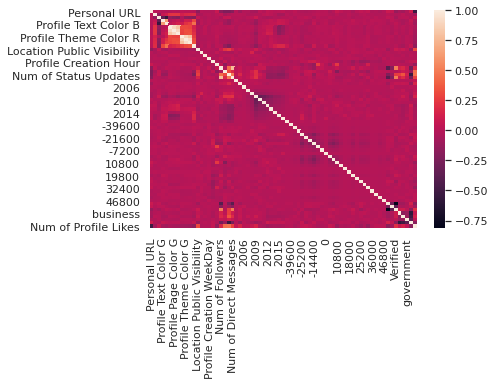

In [ ]:
corr = train_data.corr()
sns.heatmap(corr)

In [ ]:
cor_data = train_data
cor_data.dtypes

Personal URL                    int64
Profile Cover Image Status      int64
Profile Text Color R          float64
Profile Text Color G          float64
Profile Text Color B          float64
                               ...   
business                        uint8
celebrity                       uint8
government                      uint8
unknown                         uint8
Num of Profile Likes          float64
Length: 69, dtype: object

## Visualize profile colors in relation to likes

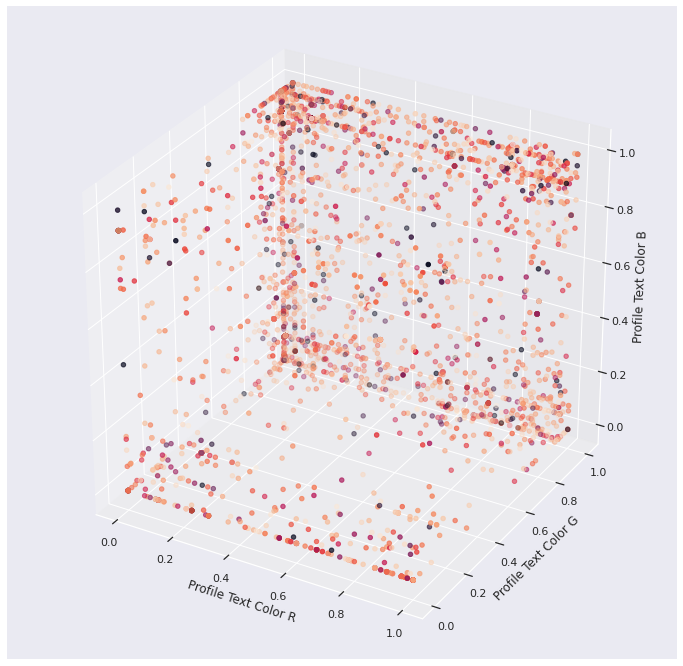

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')

xs = train_data["Profile Text Color R"]
ys = train_data["Profile Page Color G"]
zs = train_data["Profile Theme Color B"]
ax.scatter(xs, ys, zs, c=train_data["Num of Profile Likes"])

ax.set_xlabel('Profile Text Color R')
ax.set_ylabel('Profile Text Color G')
ax.set_zlabel('Profile Text Color B')

plt.show()

In [ ]:
"""from mpl_toolkits.mplot3d import Axes3D
ax = Axes3D(fig)
ax.scatter(xs,ys,zs, marker='o', s=20, c=train_data["Num of Profile Likes"], alpha=0.6)
for ii in range(0,360,1):
    ax.view_init(elev=10., azim=ii)
    fig.savefig("movie/%d.png" % ii)"""

'from mpl_toolkits.mplot3d import Axes3D\nax = Axes3D(fig)\nax.scatter(xs,ys,zs, marker=\'o\', s=20, c=train_data["Num of Profile Likes"], alpha=0.6)\nfor ii in range(0,360,1):\n    ax.view_init(elev=10., azim=ii)\n    fig.savefig("movie/%d.png" % ii)'

## Split the features and the labels

In [ ]:
train = cor_data.to_numpy()
Y_likes = train[:, -1] # for last column
X_likes = train[:, :-1] # for all but last column

X_Kaggle = test_data.to_numpy()

X_likes_scaled = minmax_scale(X_likes)

In [ ]:
columnsNamesArr = cor_data.columns.values
labels = columnsNamesArr[:-1]

## Visualize the distribution of the features

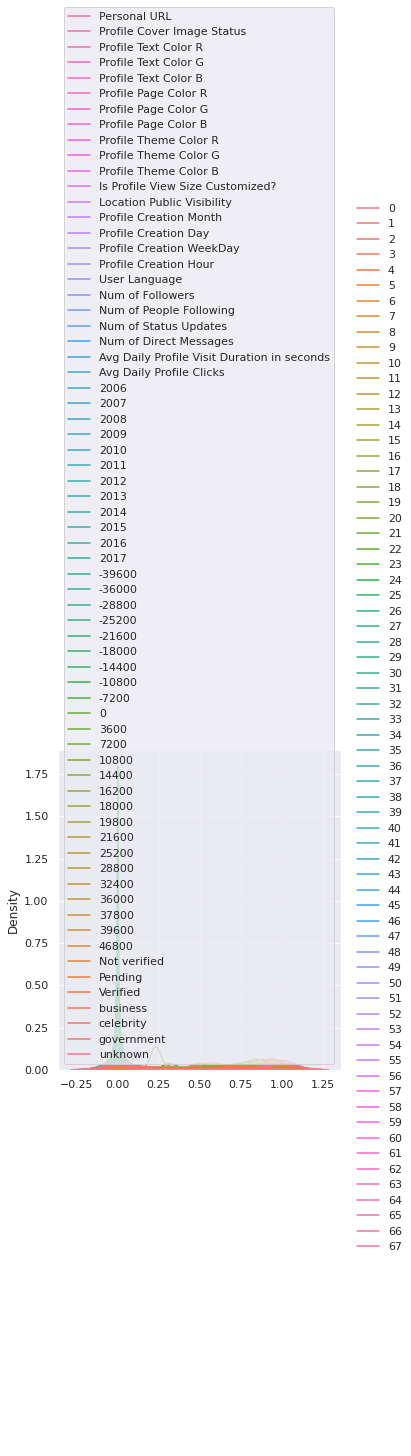

In [ ]:
sns.displot(data=X_likes_scaled, kind='kde', legend=True)
plt.legend(labels)


**Selecting features**

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression, mutual_info_regression
model = SelectKBest(f_regression, k=30)
X_selected_feat_likes = model.fit_transform(X_likes_scaled, Y_likes)
mask = np.array(model.get_support(indices=True))

selected_feats = labels[mask]
print(selected_feats)

best_i = 30

['Personal URL' 'Profile Cover Image Status' 'Profile Text Color R'
 'Profile Text Color G' 'Profile Text Color B' 'Profile Theme Color R'
 'Profile Theme Color G' 'Profile Theme Color B'
 'Is Profile View Size Customized?' 'Location Public Visibility'
 'User Language' 'Num of Followers' 'Num of People Following'
 'Num of Status Updates' 'Num of Direct Messages'
 'Avg Daily Profile Clicks' 2008 2009 2012 -21600 3600 10800 25200 32400
 'Not verified' 'Pending' 'Verified' 'business' 'celebrity' 'unknown']


In [ ]:
len(selected_feats)

30

## Defining cross-validation

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

def CV(Model, X, y, k=10, *model_args, **model_kwargs):
    validation_losses = []
    for train_index, test_index in KFold(k).split(y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        predictor = Model(*model_args, **model_kwargs)
        predictor.fit(X_train, y_train)
        y_pred = predictor.predict(X_test)
        
        validation_losses.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    
    return np.array(validation_losses)

**This was to find the best number of selected features, no need to run it every time**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn import datasets, ensemble
from sklearn.ensemble import GradientBoostingRegressor

best_i = 0
best_rmse = 10
k_losses = []
k_labels = []

for i in range(2, X_likes.shape[1]):

  X_selected_feat_likes = SelectKBest(f_regression, k=i).fit_transform(X_likes, Y_likes)
  X_selected_feat_likes.shape

  # split dataset to train and test
  X_train, X_test, y_train, y_test = train_test_split(
    X_selected_feat_likes, Y_likes, 
    test_size=0.2, 
    shuffle=True, 
    random_state=42 #  To guarantee that the split will always be the same
  )

  k_losses.append(CV(XGBRegressor, X_train, y_train, 10))#, random_state=0))
  k_labels.append(str(i))

  rmse = k_losses[-1].mean()
  if rmse < best_rmse:
    best_rmse = rmse
    best_i = i
  print(f"RMSE {i} -> {rmse}")

[16:14:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:14:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:14:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:14:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:14:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:14:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:14:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:14:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

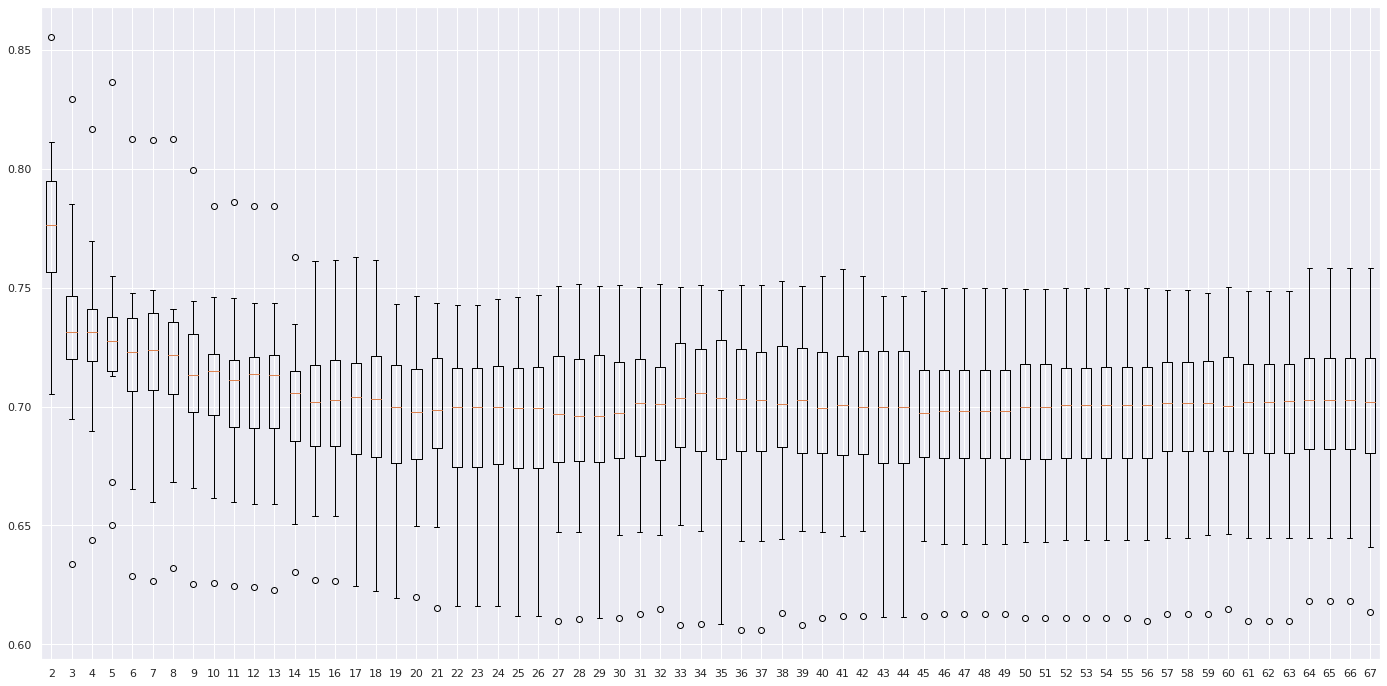

Best RMSE: 0.6906886931333893
Best number of features: 22


In [ ]:
# Display CV on features selected
plt.figure(figsize=(24,12))
plt.boxplot(k_losses, labels=k_labels)
plt.show()

print("Best RMSE: " + str(best_rmse))
print("Best number of features: " + str(best_i))

We chose K=30 because it gave us the best results on the Kaggle Public Leaderboard

In [ ]:
model = SelectKBest(f_regression, k=best_i)
X_selected_feat_likes = model.fit_transform(X_likes, Y_likes)

## Sklearn Models

**Sklearn Pipeline**

In [ ]:
from sklearn.model_selection import train_test_split

# split dataset to train and test
X_train, X_test, y_train, y_test = train_test_split(X_selected_feat_likes, Y_likes, 
                                                    test_size=0.2, 
                                                    shuffle=True, 
                                                    random_state=42 #  To guarantee that the split will always be the same
                                                    )  


**Linear Regression Classifier**

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
regressor = LinearRegression()
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

In [ ]:
## RMSE Metric
from sklearn.metrics import mean_squared_error
import math
rmse = math.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE -> {rmse}")

RMSE -> 0.68885499359464


**Random Forest Classifier**

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor()
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

In [ ]:
## RMSE Metric
from sklearn.metrics import mean_squared_error
import math
rmse = math.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE -> {rmse}")

RMSE -> 0.6928946401308663


**XGBoost Regressor**

In [ ]:
from xgboost import XGBRegressor

regressor = XGBRegressor()
regressor.fit(X_train,y_train, verbose=False)

y_pred = regressor.predict(X_test)

In [ ]:
## RMSE Metric
from sklearn.metrics import mean_squared_error
import math
rmse = math.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE -> {rmse}")

RMSE -> 0.7160971604036761


**AdaBoost Regressor**


In [ ]:
from sklearn.ensemble import AdaBoostRegressor
regressor = AdaBoostRegressor(random_state=0, n_estimators=100)
regressor.fit(X_train,y_train)

y_pred = regressor.predict(X_test)

In [ ]:
## RMSE Metric
from sklearn.metrics import mean_squared_error
import math
rmse = math.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE -> {rmse}")

RMSE -> 0.8011908329778494


**SVR Regressor**

In [ ]:
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
regressor = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2))
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

In [ ]:
## RMSE Metric
from sklearn.metrics import mean_squared_error
import math
rmse = math.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE -> {rmse}")

RMSE -> 0.679251003956598


**Gradient Boosting Regressor**

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
regressor = GradientBoostingRegressor(random_state=0)
regressor.fit(X_train,y_train)
y_pred = regressor.predict(X_test)

In [ ]:
## RMSE Metric
from sklearn.metrics import mean_squared_error
import math
rmse = math.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE -> {rmse}")

RMSE -> 0.6776021716845607


## Feature importance

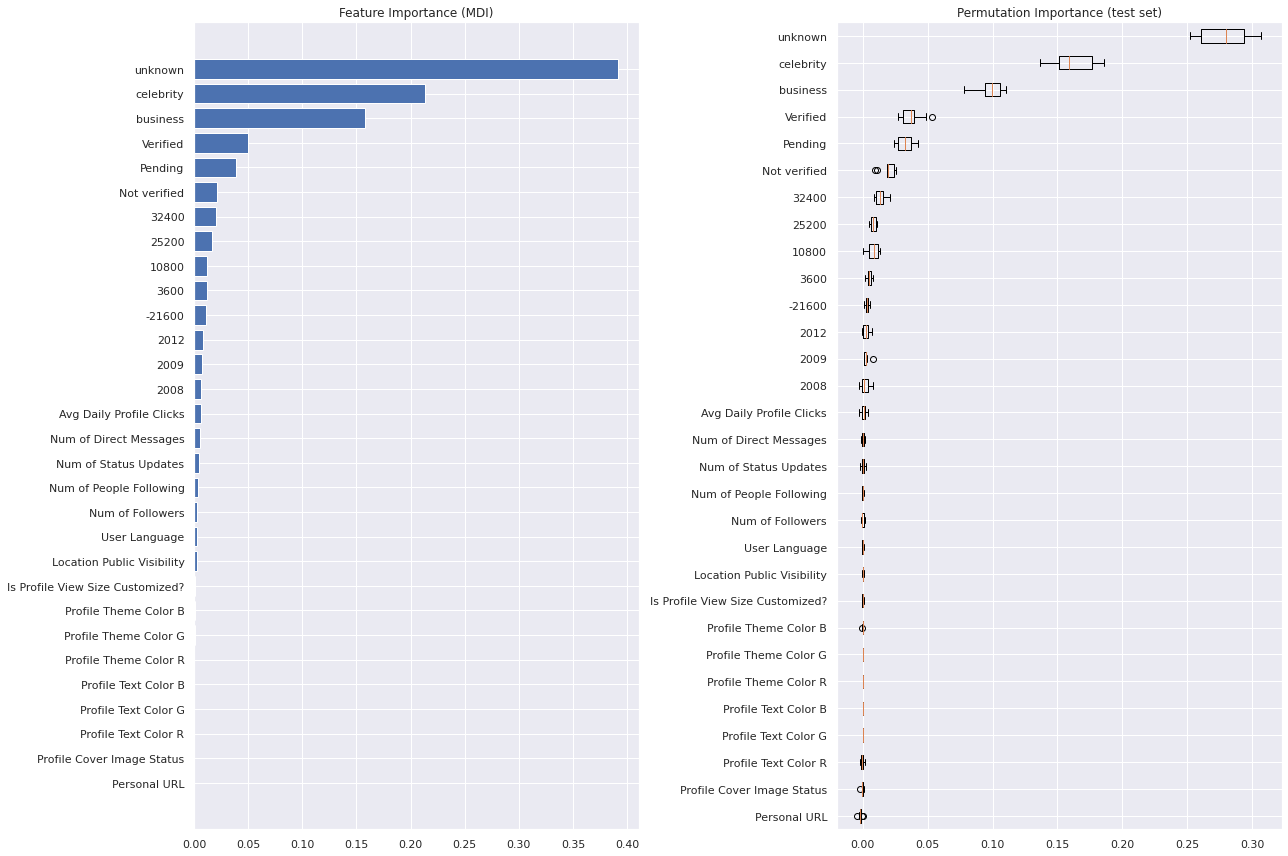

In [ ]:
mask = np.array(model.get_support(indices=True))

from sklearn.inspection import permutation_importance
feature_importance = regressor.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(18, 12))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, train_data.columns[mask])
plt.title('Feature Importance (MDI)')

result = permutation_importance(regressor, X_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(result.importances[sorted_idx].T, 
            vert=False, labels=train_data.columns[mask])
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

**Cross-validation**

**Cross-validation**

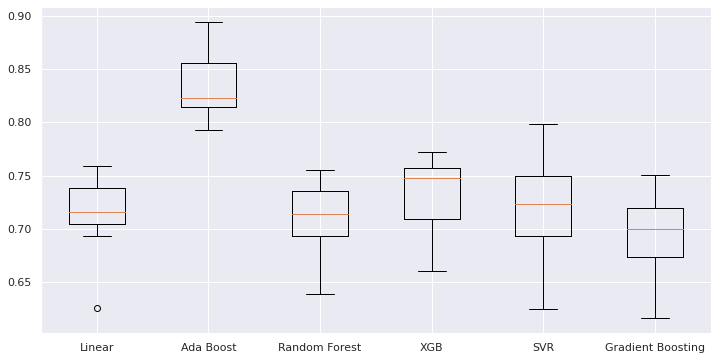

In [ ]:
from sklearn.linear_model import LinearRegression

from sklearn.ensemble import AdaBoostRegressor

from sklearn.ensemble import RandomForestRegressor

from xgboost import XGBRegressor

from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import GradientBoostingRegressor

K = 10

reg_losses = []
reg_labels = []

# Evaluate every model with CV
reg_losses.append(CV(LinearRegression, X_train, y_train, K))
reg_labels.append("Linear")

reg_losses[-1] = np.where(reg_losses[-1] > 100, np.median(reg_losses[-1]), reg_losses[-1])

reg_losses.append(CV(AdaBoostRegressor, X_train, y_train, K, random_state=0, n_estimators=100))
reg_labels.append("Ada Boost")

reg_losses.append(CV(RandomForestRegressor, X_train, y_train, K))
reg_labels.append("Random Forest")

reg_losses.append(CV(XGBRegressor, X_train, y_train, K))
reg_labels.append("XGB")

reg_losses.append(CV(make_pipeline, X_train, y_train, K, StandardScaler(), SVR(C=1.0, epsilon=0.2)))
reg_labels.append("SVR")

reg_losses.append(CV(GradientBoostingRegressor, X_train, y_train, K, random_state=0))
reg_labels.append("Gradient Boosting")

plt.figure(figsize=(12,6))
plt.boxplot(reg_losses, labels=reg_labels)
plt.show()

# Predict Kaggle Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import sklearn
%matplotlib inline

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import minmax_scale

In [2]:
train_data = pd.read_pickle("train_cleaned.pkl")
test_data = pd.read_pickle("test_cleaned.pkl")
id_test = test_data['Id']
train_data

,Id,Personal URL,Profile Cover Image Status,Profile Text Color R,Profile Text Color G,Profile Text Color B,Profile Page Color R,Profile Page Color G,Profile Page Color B,Profile Theme Color R,Profile Theme Color G,Profile Theme Color B,Is Profile View Size Customized?,Location Public Visibility,Profile Creation Month,Profile Creation Day,Profile Creation WeekDay,Profile Creation Hour,User Language,Num of Followers,Num of People Following,Num of Status Updates,Num of Direct Messages,Avg Daily Profile Visit Duration in seconds,Avg Daily Profile Clicks,Profile Image,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,-39600,-36000,-28800,-25200,-21600,-18000,-14400,-10800,-7200,0,3600,7200,10800,14400,16200,18000,19800,21600,25200,28800,32400,36000,37800,39600,46800,Not verified,Pending,Verified,business,celebrity,government,unknown,Num of Profile Likes
2,JS49LP5P72RI1OQB,0,1,0.12,0.76,0.87,0.94,0.94,0.94,0.12,0.76,0.87,0,1,10,2,4,20,6,4.128561,3.273464,3.672005,2.357935,1.518514,0.301030,JS49LP5P72RI1OQB.png,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,3.193125
4,CRSEMK4QER6LDJSA,1,1,0.35,0.26,0.30,0.97,0.97,0.97,0.00,0.00,0.00,0,1,3,31,1,13,6,3.964542,1.973128,3.514813,2.117271,0.954243,0.698970,CRSEMK4QER6LDJSA.png,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,3.033021
5,0FEKBQ59AF1LQKJP,1,1,0.00,0.49,0.76,0.87,0.93,0.96,0.20,0.58,0.82,0,1,9,30,3,17,6,4.709160,2.372912,4.200905,2.671173,1.518514,0.301030,0FEKBQ59AF1LQKJP.png,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,2.230449
8,ORJN6I5G6NA6QD0Q,0,1,0.96,0.67,0.71,0.88,0.88,0.88,0.88,0.80,0.88,0,0,5,25,0,23,6,4.281283,2.149219,3.427811,2.320146,1.322219,0.845098,ORJN6I5G6NA6QD0Q.png,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,3.093071
9,5JIAFD6132MNPAL9,0,1,0.11,0.63,0.95,0.87,0.93,0.96,0.75,0.87,0.93,1,1,10,17,0,14,6,5.899709,2.869818,4.287174,2.380211,1.544068,0.602060,5JIAFD6132MNPAL9.png,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,2.722634
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7490,EQM27ASK6HGQHDTB,0,1,0.11,0.63,0.95,0.87,0.93,0.96,0.75,0.87,0.93,1,1,2,24,3,21,8,3.386677,2.996512,3.800648,1.662758,1.462398,0.477121,EQM27ASK6HGQHDTB.png,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,3.820661
7492,3QIOBBC2TCMCMOM8,0,1,0.00,0.52,0.71,0.87,0.93,0.96,0.75,0.87,0.93,0,0,8,1,0,6,6,4.893079,2.484300,3.926805,2.459392,1.531479,0.477121,3QIOBBC2TCMCMOM8.png,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,3.388101
7494,QSFDKHOHMHRNGS65,1,1,0.00,0.52,0.71,0.87,0.93,0.96,0.75,0.87,0.93,0,1,7,12,1,21,6,5.948095,2.290035,3.417638,3.085291,1.361728,0.301030,QSFDKHOHMHRNGS65.png,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,2.588832
7495,KP5DR7CTN8CNLG8P,0,0,0.29,0.03,0.03,0.87,0.93,0.96,0.00,0.00,0.00,0,0,1,20,3,20,6,3.784403,1.886491,2.993877,1.755875,1.414973,0.954243,KP5DR7CTN8CNLG8P.png,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,3.137987


In [3]:
train_data.drop(columns=['Id', 'Profile Image'], inplace=True)
test_data.drop(columns=['Id', 'Profile Image'], inplace=True)
train_data

,Personal URL,Profile Cover Image Status,Profile Text Color R,Profile Text Color G,Profile Text Color B,Profile Page Color R,Profile Page Color G,Profile Page Color B,Profile Theme Color R,Profile Theme Color G,Profile Theme Color B,Is Profile View Size Customized?,Location Public Visibility,Profile Creation Month,Profile Creation Day,Profile Creation WeekDay,Profile Creation Hour,User Language,Num of Followers,Num of People Following,Num of Status Updates,Num of Direct Messages,Avg Daily Profile Visit Duration in seconds,Avg Daily Profile Clicks,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,-39600,-36000,-28800,-25200,-21600,-18000,-14400,-10800,-7200,0,3600,7200,10800,14400,16200,18000,19800,21600,25200,28800,32400,36000,37800,39600,46800,Not verified,Pending,Verified,business,celebrity,government,unknown,Num of Profile Likes
2,0,1,0.12,0.76,0.87,0.94,0.94,0.94,0.12,0.76,0.87,0,1,10,2,4,20,6,4.128561,3.273464,3.672005,2.357935,1.518514,0.301030,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,3.193125
4,1,1,0.35,0.26,0.30,0.97,0.97,0.97,0.00,0.00,0.00,0,1,3,31,1,13,6,3.964542,1.973128,3.514813,2.117271,0.954243,0.698970,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,3.033021
5,1,1,0.00,0.49,0.76,0.87,0.93,0.96,0.20,0.58,0.82,0,1,9,30,3,17,6,4.709160,2.372912,4.200905,2.671173,1.518514,0.301030,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,2.230449
8,0,1,0.96,0.67,0.71,0.88,0.88,0.88,0.88,0.80,0.88,0,0,5,25,0,23,6,4.281283,2.149219,3.427811,2.320146,1.322219,0.845098,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,3.093071
9,0,1,0.11,0.63,0.95,0.87,0.93,0.96,0.75,0.87,0.93,1,1,10,17,0,14,6,5.899709,2.869818,4.287174,2.380211,1.544068,0.602060,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,2.722634
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7490,0,1,0.11,0.63,0.95,0.87,0.93,0.96,0.75,0.87,0.93,1,1,2,24,3,21,8,3.386677,2.996512,3.800648,1.662758,1.462398,0.477121,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,3.820661
7492,0,1,0.00,0.52,0.71,0.87,0.93,0.96,0.75,0.87,0.93,0,0,8,1,0,6,6,4.893079,2.484300,3.926805,2.459392,1.531479,0.477121,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,3.388101
7494,1,1,0.00,0.52,0.71,0.87,0.93,0.96,0.75,0.87,0.93,0,1,7,12,1,21,6,5.948095,2.290035,3.417638,3.085291,1.361728,0.301030,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,2.588832
7495,0,0,0.29,0.03,0.03,0.87,0.93,0.96,0.00,0.00,0.00,0,0,1,20,3,20,6,3.784403,1.886491,2.993877,1.755875,1.414973,0.954243,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,3.137987


In [4]:
train = train_data.to_numpy()
y_train = train[:, -1] # for last column
X_train = train[:, :-1] # for all but last column

X_test = test_data.to_numpy()

X_train_scaled = minmax_scale(X_train)

In [5]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression, mutual_info_regression

best_f = SelectKBest(f_regression, k=30)



X_selected_feat_likes = best_f.fit_transform(X_train, y_train)
X_test_selected_feats = best_f.transform(X_test)
X_train_selected_feats = best_f.transform(X_train)

mask = np.array(best_f.get_support(indices=True))



In [6]:
from xgboost import XGBRegressor
from sklearn import datasets, ensemble
from sklearn.ensemble import GradientBoostingRegressor

regressor = XGBRegressor()
#regressor = GradientBoostingRegressor(random_state=0)
regressor.fit(X_train_selected_feats, y_train)


y_pred = regressor.predict(X_test_selected_feats)

[19:53:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [7]:
import csv
preds = 10 ** y_pred - 1
preds = np.around(preds)

with open('predictions.csv', 'w', newline='') as csvfile:
    spamwriter = csv.writer(csvfile, delimiter=',', quotechar='|', 
                            quoting=csv.QUOTE_MINIMAL)
    
    spamwriter.writerow(['Id', 'Predicted'])

    for id, pred in zip(id_test, preds):
      spamwriter.writerow([id, int(pred)])
